# Initial tests for DEM validation script

In [117]:
import rasterio 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

In [118]:
#jupyter magic
%matplotlib notebook

In [119]:
#path to DEM
demfile = 'C:\\jlogan_python\\demValidation\\data\\2017-1101-LPD_UAS-SfM-DEM_10cm.tif'

#path to check points csv:
checkfile = 'C:\\jlogan_python\\demValidation\\data\\2017-1101-LPD-UAS_backpackTopoValidation.csv'

In [120]:
#get check points into dataframe
df = pd.read_csv(checkfile)
#rename z column to distinguish from dem
df.rename(columns={'z':'gps_z'}, inplace=True)
df.head()


,pid,n,e,gps_z,code
0,10000,4026533.048,619859.129,318.097,BPACK
1,10001,4026532.466,619859.025,318.111,BPACK
2,10002,4026532.056,619859.497,318.098,BPACK
3,10003,4026531.544,619859.910,318.081,BPACK
4,10004,4026531.075,619860.394,318.072,BPACK


In [121]:
#load DEM (geotiff) using rasterio
dataset = rasterio.open(demfile)

#get numpy array
dem = dataset.read(1)

#convert nodatavalues to nans
dem[dem==dataset.nodatavals] = np.nan

#### How to use affine transform, from https://www.perrygeo.com/python-affine-transforms.html

#### Using rasterio and affine
`a = ds.affine`
#### col, row to x, y
`x, y = a * (col, row)`
#### x, y to col, row
`col, row = ~a * (x, y)`

In [122]:
#get affine transform
a = dataset.affine
a

Affine(0.0999999999999953, 0.0, 619541.2000000001,
       0.0, -0.0999999999999891, 4027043.4)

#### Test affine transform below

In [123]:
#Test affine
#Top left coords of dataset should be 0,0
col, row = ~a * (dataset.bounds.left, dataset.bounds.top)
print('col ' + str(col) + ', row ' + str(row))


col 0.0, row 0.0


In [124]:
#Test affine
#Use affine to get geocoords of col 0, row 0. Should equal dataset.bounds
x, y = a * (col, row)
print('dataset.bounds.left = ' + str(dataset.bounds.left) + '\n' +
     'dataset.bounds.top = ' + str(dataset.bounds.top))
print('x = ' + str(x) + '\n' +
     'y = ' + str(y))

dataset.bounds.left = 619541.2000000001
dataset.bounds.top = 4027043.4
x = 619541.2000000001
y = 4027043.4


In [125]:
#Test affine
#get array coords with geocoords from validation file
north = df.loc[0, 'n']
east = df.loc[0, 'e']
col, row = ~a * (east, north)
#print(str(col) + ', ' + str(row))
~a * (east, north)
#need to check on order of x,y and col, row

(3179.2899999991059, 5103.5199999958277)

In [126]:
#Test scipy ndimage map_coordinates to do bilinear interp
z = ndimage.map_coordinates(dem, [[row],[col]], order=1, mode='constant', cval=-9999)
print(str(z))

[ 318.0774231]


In [127]:
#check value of grid cells around point
dem[np.int(np.floor(row)):np.int(np.ceil(row))+1,np.int(np.floor(col)):np.int(np.ceil(col))+1]

array([[ 318.08499146,  318.07901001],
       [ 318.07901001,  318.05499268]], dtype=float32)

#### Affine transform works.  Now use it to get row/col 


In [128]:
#use affine to get DEM row, column into df
df['demcol'], df['demrow'] = ~a * (df['e'], df['n'])

df.head()

,pid,n,e,gps_z,code,demcol,demrow
0,10000,4026533.048,619859.129,318.097,BPACK,3179.29,5103.52
1,10001,4026532.466,619859.025,318.111,BPACK,3178.25,5109.34
2,10002,4026532.056,619859.497,318.098,BPACK,3182.97,5113.44
3,10003,4026531.544,619859.910,318.081,BPACK,3187.10,5118.56
4,10004,4026531.075,619860.394,318.072,BPACK,3191.94,5123.25


In [129]:
#use map_coordinates to do bilinear interp and place result in new df column
#need to transpose to get into rows to place into df
df['dem_z'] = np.transpose(ndimage.map_coordinates(dem, 
                                                   [[df['demrow']],[df['demcol']]], 
                                                   order=1, mode='constant', cval=-9999))

#drop rows which are nan
df.dropna(axis=0, subset=['dem_z'], inplace=True)

#drop rows which were assigned constant -9999 (outside of dem bounds)
df = df.loc[df['dem_z'] != -9999]

In [130]:
df.head()

,pid,n,e,gps_z,code,demcol,demrow,dem_z
0,10000,4026533.048,619859.129,318.097,BPACK,3179.29,5103.52,318.077423
1,10001,4026532.466,619859.025,318.111,BPACK,3178.25,5109.34,318.061218
2,10002,4026532.056,619859.497,318.098,BPACK,3182.97,5113.44,318.070221
3,10003,4026531.544,619859.910,318.081,BPACK,3187.10,5118.56,318.067139
4,10004,4026531.075,619860.394,318.072,BPACK,3191.94,5123.25,318.094666


In [131]:
#calculate residual (obs - pred), or (check-dem)
df['resid'] = df['gps_z'] - df['dem_z']

#Calc RMSE, mean, mae, stdev
rmse = ((df['gps_z'] - df['dem_z']) ** 2).mean() ** .5
mean_error = df['resid'].mean()
mae = df['resid'].abs().mean()
stdev = df['resid'].std()

#print results
print('RMSE: ' + '{:0.3f}'.format(rmse))
print('Mean offset: ' + '{:0.3f}'.format(mean_error))
print('Std. Dev.: ' + '{:0.3f}'.format(stdev))
print('MAE: ' + '{:0.3f}'.format(mae))


RMSE: 0.060
Mean offset: 0.024
Std. Dev.: 0.055
MAE: 0.049


#### Plot histogram


<IPython.core.display.Javascript object>


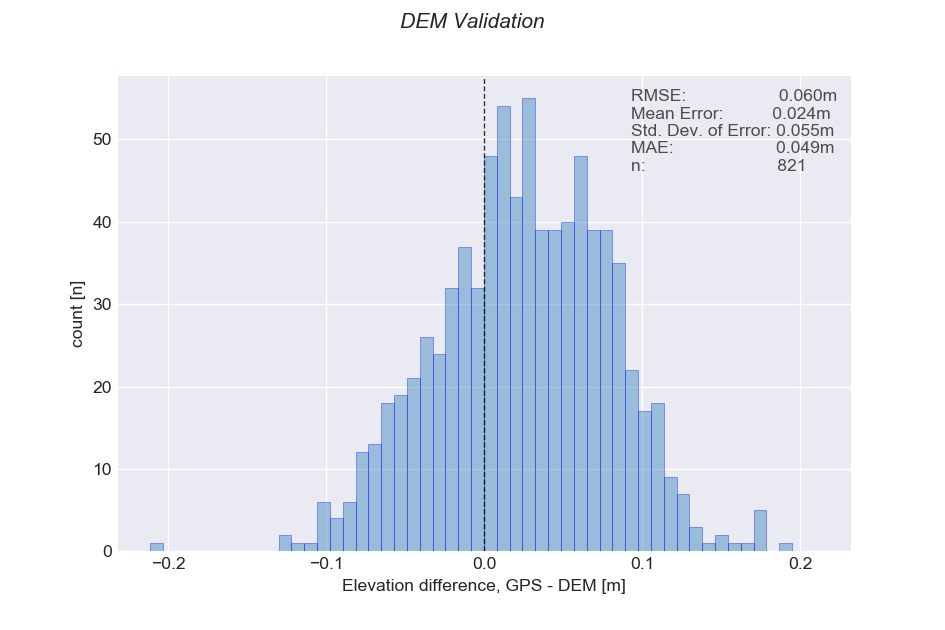

Text(0.5,0.98,'DEM Validation')

In [149]:
#jupyter magic
%matplotlib notebook
#set seaborn style
sns.set_style('darkgrid')
fig_hist = plt.figure(figsize=(7.5,5))
    
ax =sns.distplot(df['resid'], bins=50, kde=False, hist_kws=dict(edgecolor="b", linewidth=0.5))
#set xlimit to be equal on either side of zero, using abs max of currently displayed range
ax.set_xlim(np.abs(np.array(ax.get_xlim())).max()*-1, np.abs(np.array(ax.get_xlim())).max())
#plot vertical line at 0
ax.axvline(x=0, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
    
#make annotation str
s = ('RMSE:                   ' + "{:0.3f}".format(rmse) + 'm' + '\n' +
     'Mean Error:          ' + "{:0.3f}".format(mean_error) + 'm' + '\n' +
     'Std. Dev. of Error: ' + "{:0.3f}".format(stdev) + 'm' + '\n' +
     'MAE:                     ' + "{:0.3f}".format(mae) + 'm'  + '\n' +
     'n:                           ' + str(len(df)))
#place text at 40% on right, 80% top
ax.text(np.abs(np.array(ax.get_xlim())).max()*0.4, np.array(ax.get_ylim()).max()*0.8, s, alpha=0.8, fontsize=10)
    
ax.set_xlabel('Elevation difference, GPS - DEM [m]')
ax.set_ylabel('count [n]')
    
fig_hist.suptitle('DEM Validation', fontstyle='italic')

#### Experiments with mapping options below

<IPython.core.display.Javascript object>


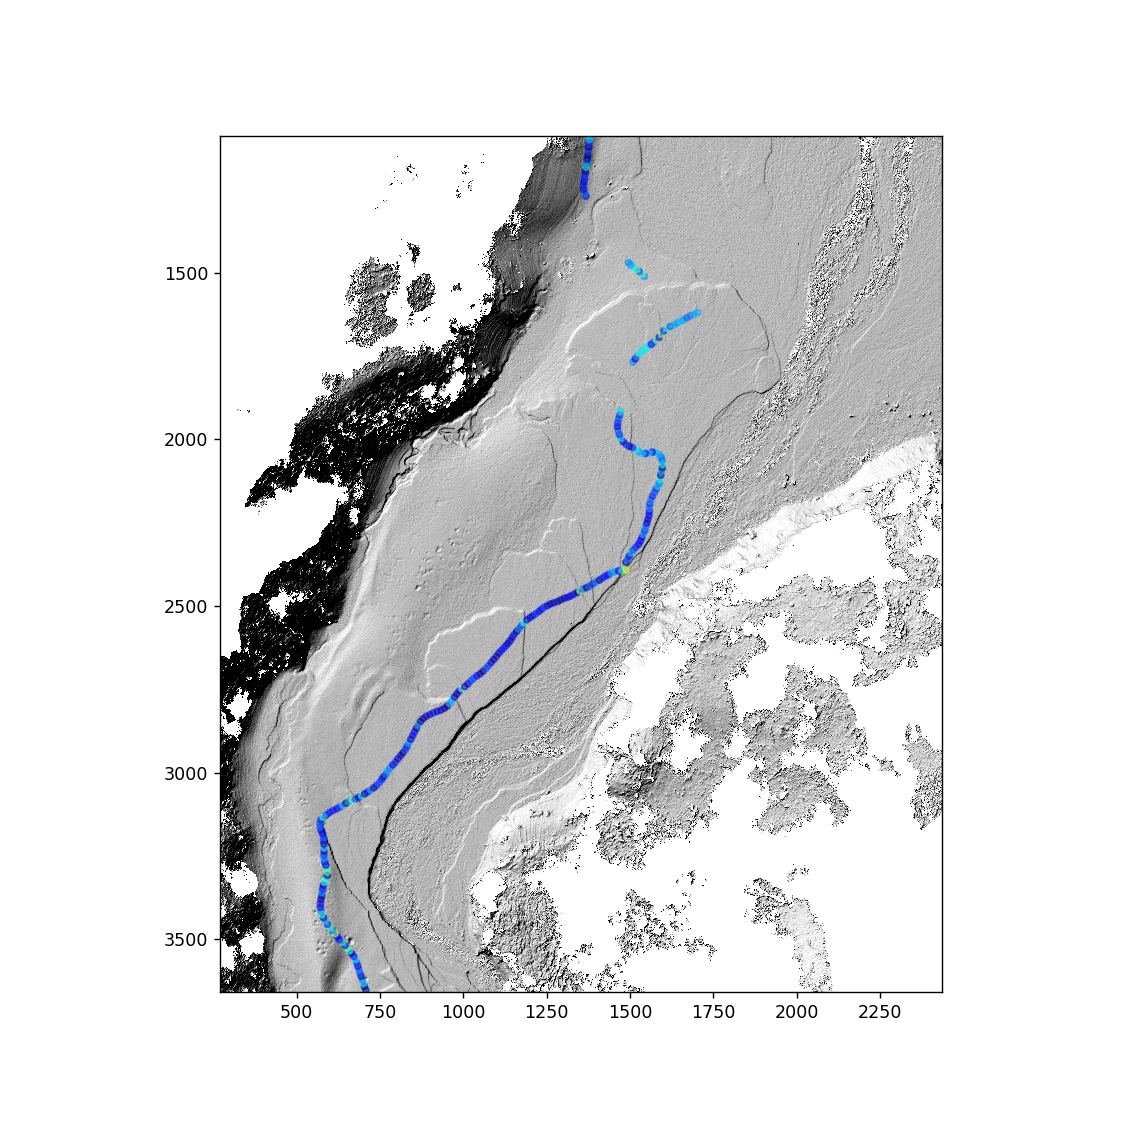

In [151]:
#on the fly hillshading
#from https://mtaplotlib.org/examples/specialty_plots/topographic_hillshading.html

#remove seaborn
sns.reset_orig()
%matplotlib notebook

from matplotlib.colors import LightSource
ls = LightSource(azdeg=315,altdeg=45)
fig=plt.figure(figsize=(9,9))
plt.imshow(ls.hillshade(dem, vert_exag=1.5, dx=0.1, dy=0.1), cmap='gray')

#plot points, using img coords, colors as abs(resid)
plt.scatter(x=df['demcol'], y=df['demrow'], c=df['resid'].abs(),cmap=plt.cm.jet, s=12,alpha=0.5)

In [142]:
#make a hillshade
#function from  http://neondataskills.org/lidar/create-hillshade-py/

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

#run function (vertical exaggerate 15)
dem_hillshade = hillshade(dem*15,300,45)


<IPython.core.display.Javascript object>


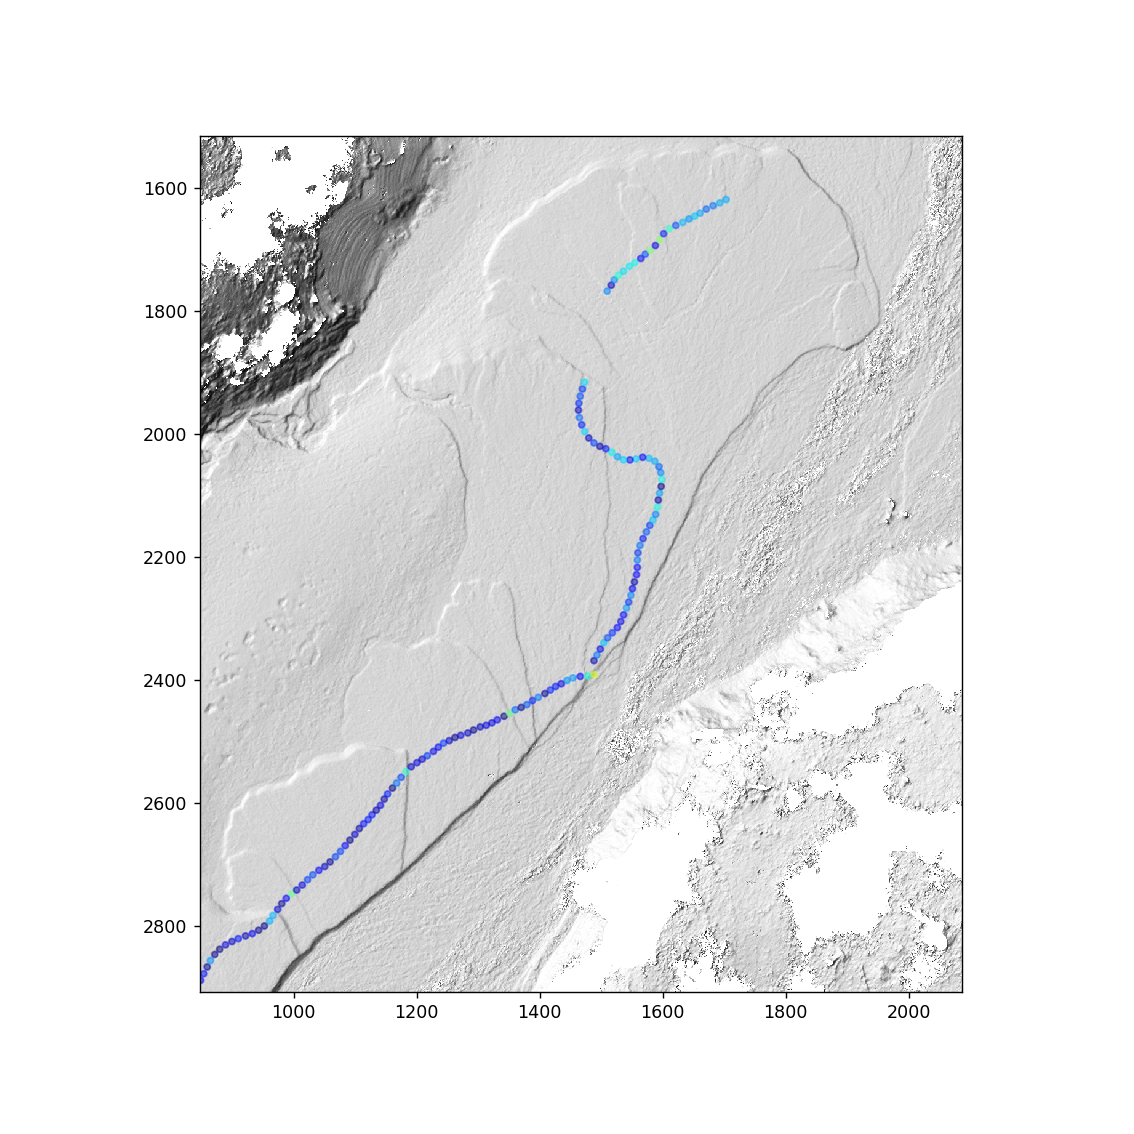

In [144]:
#remove seaborn set first
sns.reset_orig()

fig=plt.figure(figsize=(9,9))
imgplot = plt.imshow(dem_hillshade, cmap='gray')

#plot points, using img coords, colors as abs(resid)
plt.scatter(x=df['demcol'], y=df['demrow'], c=df['resid'].abs(),cmap=plt.cm.jet, s=12,alpha=0.5)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


<IPython.core.display.Javascript object>


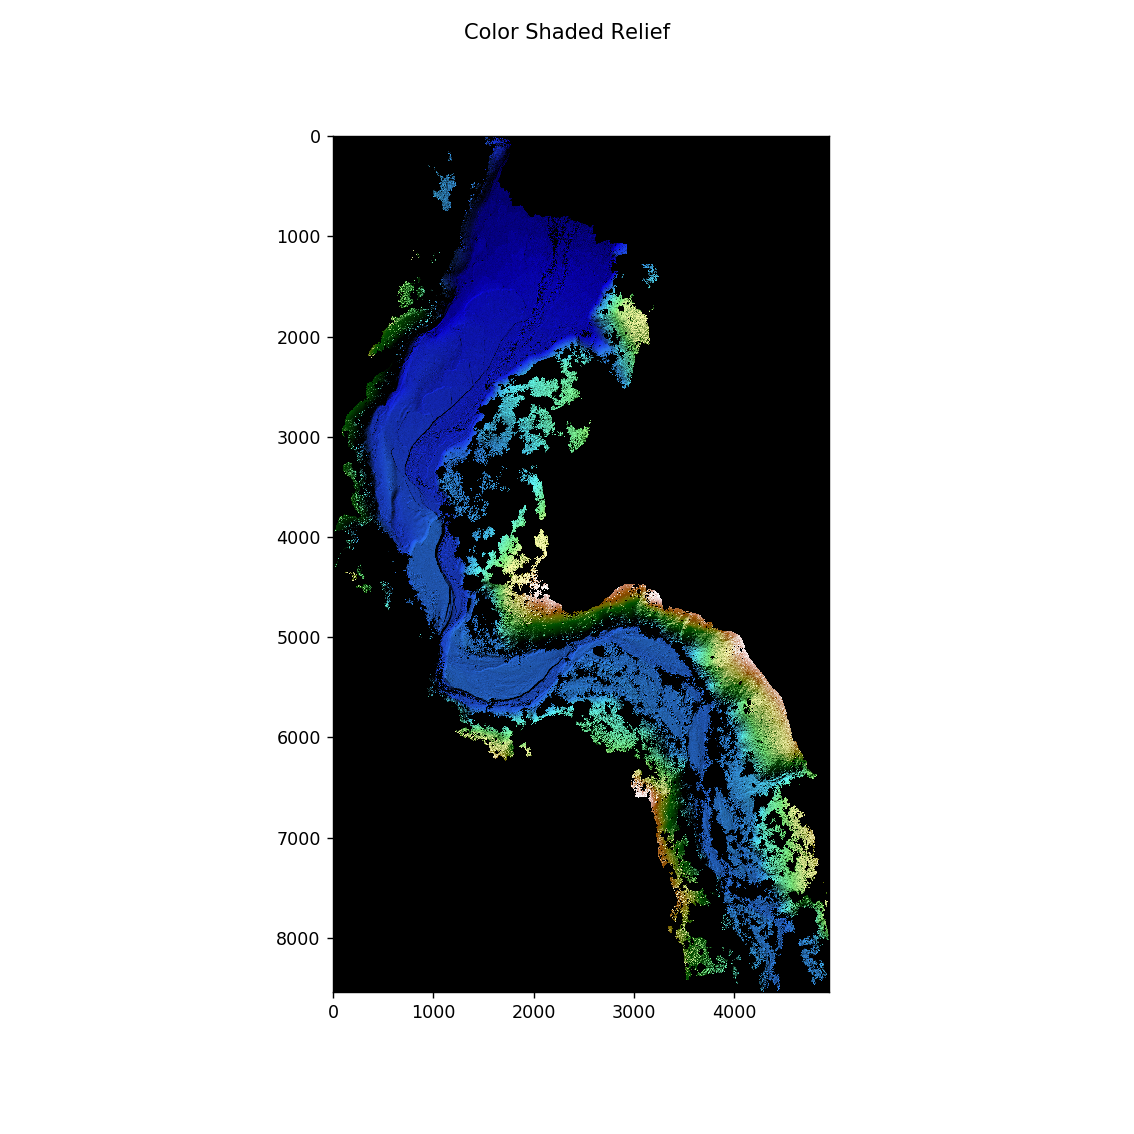

In [96]:
#Color shaded relief
cmap = plt.cm.gist_earth
rgb = ls.shade(dem, cmap=cmap, blend_mode='overlay', vert_exag=2, dx=0.1, dy=0.1, vmin=np.nanmin(dem), vmax=np.nanmax(dem))
fig=plt.figure(figsize=(9,9))
plt.suptitle('Color Shaded Relief')
plt.imshow(rgb)
